# Stroke Predictions using Machine Learning

### By Derek Lilienthal

Data: https://www.kaggle.com/fedesoriano/stroke-prediction-dataset

**Context**  
According to the World Health Organization (WHO) stroke is the 2nd leading cause of death globally, responsible for approximately 11% of total deaths.
This dataset is used to predict whether a patient is likely to get stroke based on the input parameters like gender, age, various diseases, and smoking status. Each row in the data provides relavant information about the patient.

**Attribute Information**  
1) id: unique identifier  
2) gender: "Male", "Female" or "Other"  
3) age: age of the patient  
4) hypertension: 0 if the patient doesn't have hypertension, 1 if the patient has hypertension  
5) heart_disease: 0 if the patient doesn't have any heart diseases, 1 if the patient has a heart disease  
6) ever_married: "No" or "Yes"  
7) work_type: "children", "Govt_jov", "Never_worked", "Private" or "Self-employed"  
8) Residence_type: "Rural" or "Urban"  
9) avg_glucose_level: average glucose level in blood  
10) bmi: body mass index  
11) smoking_status: "formerly smoked", "never smoked", "smokes" or "Unknown"\*   
12) stroke: 1 if the patient had a stroke or 0 if not  
\*Note: "Unknown" in smoking_status means that the information is unavailable for this patient  

<hr>

**Import Libraries**

In [105]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import confusion_matrix, average_precision_score

**Global Parameters**

In [106]:
font_size = 22
plt.rcParams.update({'font.size': font_size})
plt.rcParams['figure.figsize'] = (20.0, 10.0)
sns.set(color_codes=True)
sns.set(font_scale=2)

**Import Data**

In [107]:
# Import all the columns except for the ID column
df = pd.read_csv("healthcare-dataset-stroke-data.csv", usecols = np.arange(1,12))

### Data Summarization

*General Information about the Data Set*

In [108]:
df = df.convert_dtypes()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5110 non-null   string 
 1   age                5110 non-null   float64
 2   hypertension       5110 non-null   Int64  
 3   heart_disease      5110 non-null   Int64  
 4   ever_married       5110 non-null   string 
 5   work_type          5110 non-null   string 
 6   Residence_type     5110 non-null   string 
 7   avg_glucose_level  5110 non-null   float64
 8   bmi                4909 non-null   float64
 9   smoking_status     5110 non-null   string 
 10  stroke             5110 non-null   Int64  
dtypes: Int64(3), float64(3), string(5)
memory usage: 454.2 KB


*Top 5 rows in the data set*

In [109]:
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


*Number of Observations (rows) and Features (columns)*

In [110]:
df.shape

(5110, 11)

*Summary Statistics of Numeric Columns*

In [111]:
df.describe()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


*Summary Statistics of Categorical Columns*

In [112]:
df.describe(include=['string'])

,gender,ever_married,work_type,Residence_type,smoking_status
count,5110,5110,5110,5110,5110
unique,3,2,5,2,4
top,Female,Yes,Private,Urban,never smoked
freq,2994,3353,2925,2596,1892


*Missing Values in the dataset*

In [113]:
is_missing = df.isna().sum()
percent_missing = (df.isna().sum() / df.shape[0]) * 100
result = pd.concat([is_missing, percent_missing], axis=1)
result.rename(columns={0:"Missing Counts",1:"Percentage Missing"})

,Missing Counts,Percentage Missing
gender,0,0.000000
age,0,0.000000
hypertension,0,0.000000
heart_disease,0,0.000000
ever_married,0,0.000000
work_type,0,0.000000
Residence_type,0,0.000000
avg_glucose_level,0,0.000000
bmi,201,3.933464
smoking_status,0,0.000000


### Data Exploration

*Categorizing features*

In [114]:
categorical_columns = [] # Store all the columns names that are categorical variables
numeric_columns = [] # Store all the column names that are numeric variables
for i in range(df.shape[1]):
    dtype = str(df.dtypes[i])
    if dtype == 'string':
        categorical_columns.append(df.columns[i])
    else:
        numeric_columns.append(df.columns[i])

*Below shows how many unique values there are for each feature in the data set*

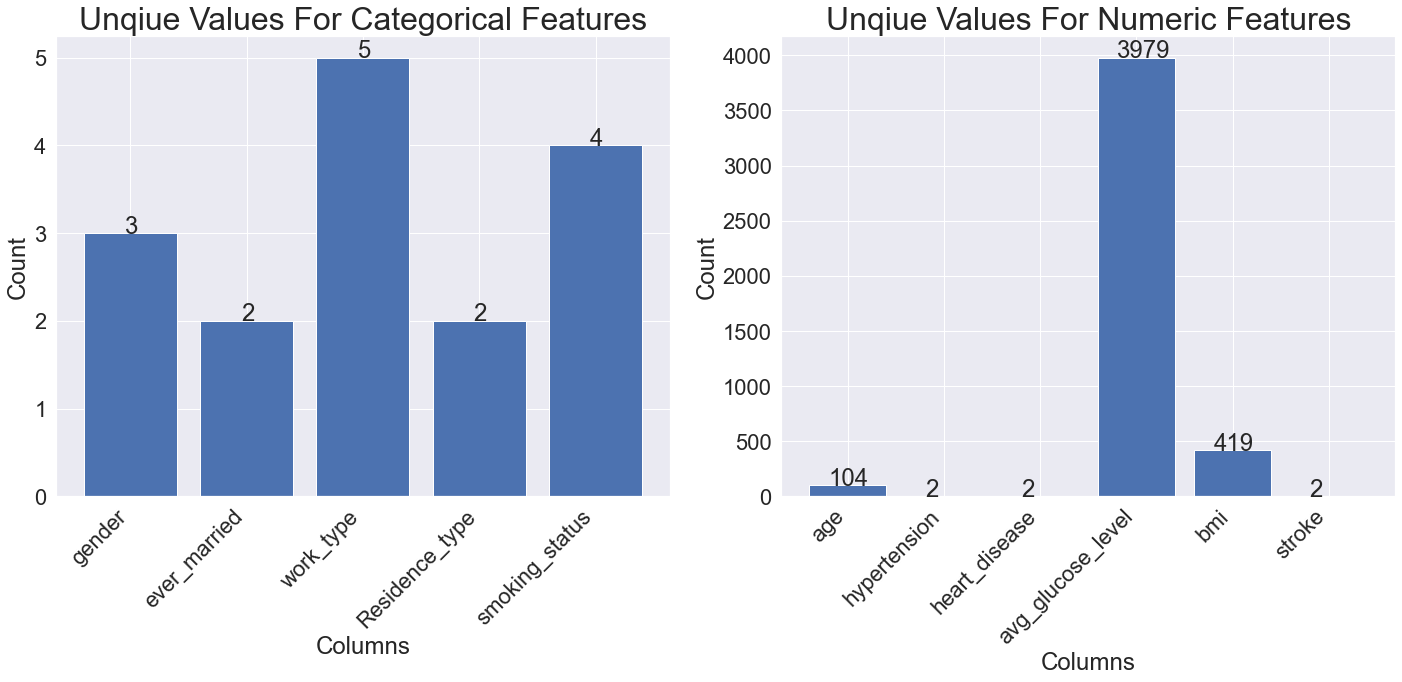

In [115]:
cat_dict = {}
for col in categorical_columns:
    cat_dict[col] = df[col].unique().size
    
num_dict = {}
for col in numeric_columns:
    num_dict[col] = df[col].unique().size

fig, (ax1, ax2) = plt.subplots(1,2, sharex=False, sharey=False)

# Code for left graph
plt.sca(ax1)
plt.bar(x=cat_dict.keys(), height=cat_dict.values())
plt.xticks(rotation=45, horizontalalignment='right')
plt.title('Unqiue Values For Categorical Features', fontsize=font_size+10)
plt.xlabel('Columns')
plt.ylabel('Count')
for i, col in enumerate(ax1.patches):
    plt.text(col.get_x()+0.35, col.get_height(), list(cat_dict.values())[i]);

# Code for right graph
plt.sca(ax2)
plt.bar(x=num_dict.keys(), height=num_dict.values())
plt.xticks(rotation=45, horizontalalignment='right')
plt.title('Unqiue Values For Numeric Features', fontsize=font_size+10)
plt.xlabel('Columns')
plt.ylabel('Count')
for i, col in enumerate(ax2.patches):
    plt.text(col.get_x()+0.2, col.get_height(), list(num_dict.values())[i]);
    
plt.tight_layout()

From the left graph, we can see **hypertension**, **heart_disease**, and **stroke** are categorical features that are encoded as numeric.

*Distribution of Non-Binary Numeric Data*

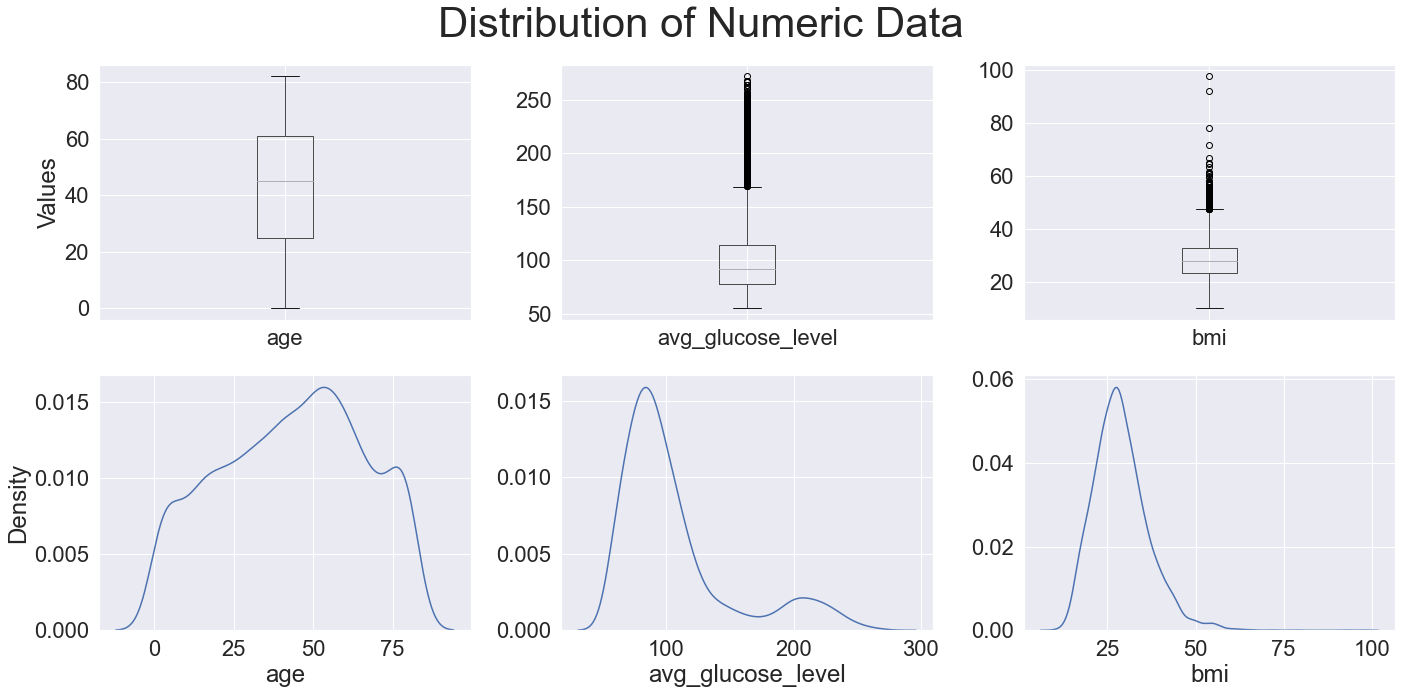

In [116]:
fig, axes = plt.subplots(2, 3, sharex=False, sharey=False)

df.boxplot(['age'], ax=axes[0,0]).set(ylabel="Values")
df.boxplot(['avg_glucose_level'], ax=axes[0,1])
df.boxplot(['bmi'], ax=axes[0,2])
sns.kdeplot(df['age'], ax=axes[1,0]) 
sns.kdeplot(df['avg_glucose_level'], ax=axes[1,1]).set(ylabel=None)
sns.kdeplot(df['bmi'], ax=axes[1,2]).set(ylabel=None) 
plt.tight_layout()
plt.suptitle("Distribution of Numeric Data", fontsize = font_size + 20)
plt.subplots_adjust(top = 0.9)

*Counts of all categorical columns*

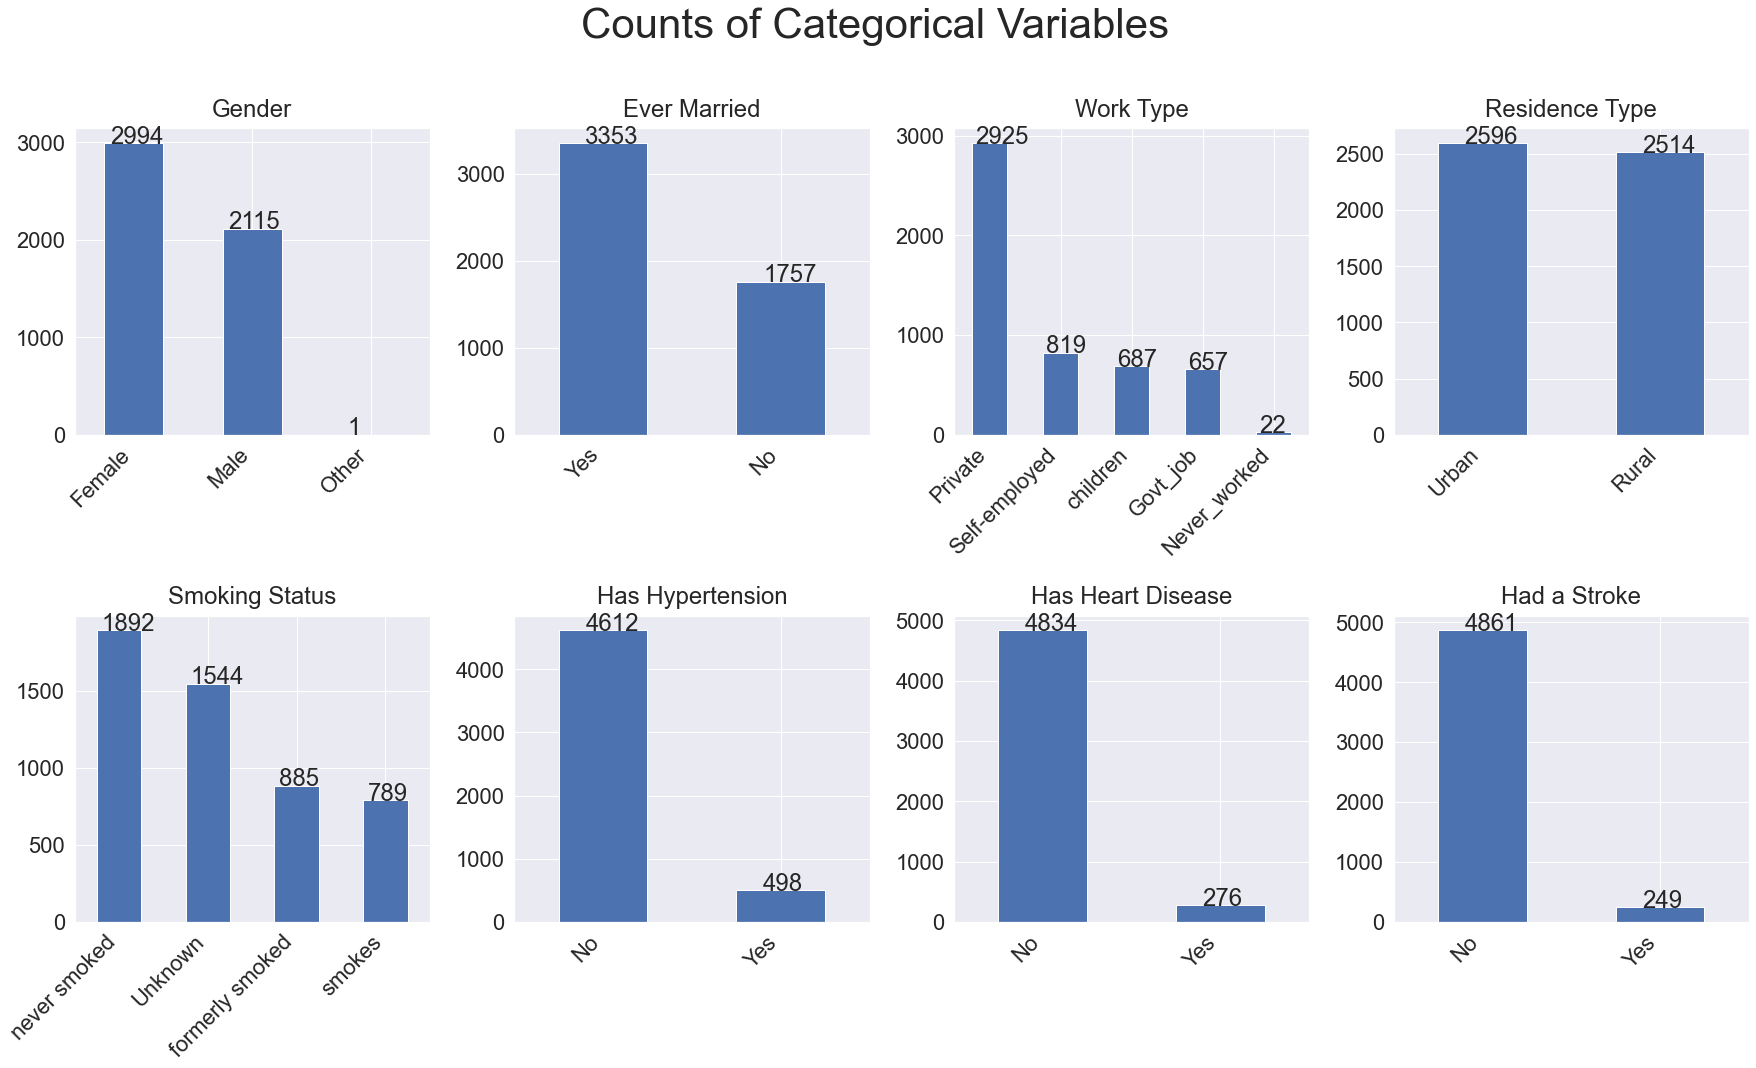

In [117]:
numeric_categorical_columns = ['hypertension', 'heart_disease', 'stroke']
all_categorical_columns = categorical_columns + numeric_categorical_columns

fig, axes = plt.subplots(2, 4, sharex=False, sharey=False, figsize=(25,15))

df['gender'].value_counts().plot.bar(ax=axes[0,0])
plt.sca(axes[0,0])
for i, col in enumerate(axes[0,0].patches):
    plt.text(col.get_x()+0.05, col.get_height(), df['gender'].value_counts().tolist()[i]);
plt.title('Gender', y=1.02)
plt.xticks(rotation=45, horizontalalignment='right')

df['ever_married'].value_counts().plot.bar(ax=axes[0,1])
plt.sca(axes[0,1])
for i, col in enumerate(axes[0,1].patches):
    plt.text(col.get_x()+0.15, col.get_height(), df['ever_married'].value_counts().tolist()[i]);
plt.title('Ever Married', y=1.02)
plt.xticks(rotation=45, horizontalalignment='right')

df['work_type'].value_counts().plot.bar(ax=axes[0,2])
plt.sca(axes[0,2])
for i, col in enumerate(axes[0,2].patches):
    plt.text(col.get_x()+0.05, col.get_height(), df['work_type'].value_counts().tolist()[i]);
plt.title('Work Type', y=1.02)
plt.xticks(rotation=45, horizontalalignment='right')

df['Residence_type'].value_counts().plot.bar(ax=axes[0,3])
plt.sca(axes[0,3])
for i, col in enumerate(axes[0,3].patches):
    plt.text(col.get_x()+0.15, col.get_height(), df['Residence_type'].value_counts().tolist()[i]);
plt.title('Residence Type', y=1.02)
plt.xticks(rotation=45, horizontalalignment='right')

df['smoking_status'].value_counts().plot.bar(ax=axes[1,0])
plt.sca(axes[1,0])
for i, col in enumerate(axes[1,0].patches):
    plt.text(col.get_x()+0.05, col.get_height(), df['smoking_status'].value_counts().tolist()[i]);
plt.title('Smoking Status', y=1.02)
plt.xticks(rotation=45, horizontalalignment='right')

df['hypertension'].value_counts().plot.bar(ax=axes[1,1])
plt.sca(axes[1,1])
for i, col in enumerate(axes[1,1].patches):
    plt.text(col.get_x()+0.15, col.get_height(), df['hypertension'].value_counts().tolist()[i]);
plt.title('Has Hypertension', y=1.02)
plt.xticks([0,1], ['No','Yes'], rotation=45, horizontalalignment='right')

df['heart_disease'].value_counts().plot.bar(ax=axes[1,2])
plt.sca(axes[1,2])
for i, col in enumerate(axes[1,2].patches):
    plt.text(col.get_x()+0.15, col.get_height(), df['heart_disease'].value_counts().tolist()[i]);
plt.title('Has Heart Disease', y=1.02)
plt.xticks([0,1], ['No','Yes'], rotation=45, horizontalalignment='right')

df['stroke'].value_counts().plot.bar(ax=axes[1,3])
plt.sca(axes[1,3])
for i, col in enumerate(axes[1,3].patches):
    plt.text(col.get_x()+0.15, col.get_height(), df['stroke'].value_counts().tolist()[i]);
plt.title('Had a Stroke', y=1.02)
plt.xticks([0,1], ['No','Yes'], rotation=45, horizontalalignment='right')

plt.suptitle('Counts of Categorical Variables', y=1, fontsize=font_size + 20)
plt.tight_layout()

*Strokes by age*

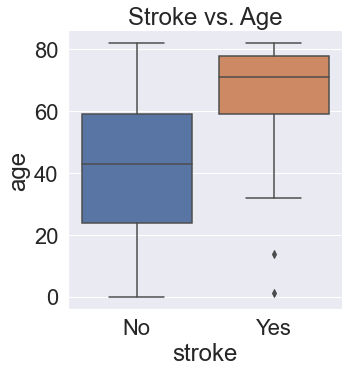

In [118]:
sns.catplot(x='stroke', y='age', kind='box', data=df)
plt.title('Stroke vs. Age')
plt.xticks([0,1], ['No','Yes']);

The graph above shows us that most people in this data set who had strokes were on average older than people who did not have a stroke.

*Strokes by age and hypertension*

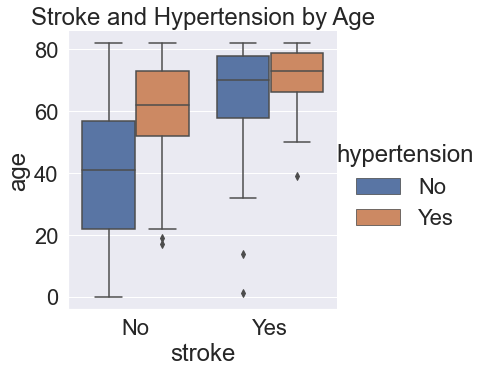

In [119]:
g = sns.catplot(x='stroke', y='age', hue='hypertension', kind='box', data=df)
plt.title('Stroke and Hypertension by Age')
plt.xticks([0,1], ['No','Yes'])
new_labels = ['No','Yes']
for text, label in zip(g._legend.texts, new_labels): text.set_text(label) # Rename Legend labels

*Stroke by Body Mass Index*

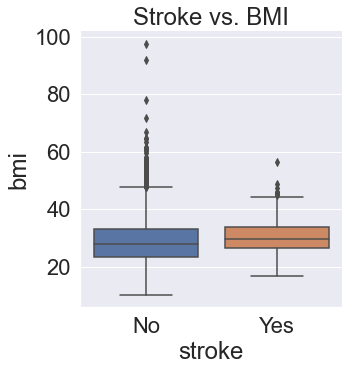

In [120]:
sns.catplot(x='stroke', y='bmi', kind='box', data=df)
plt.title('Stroke vs. BMI')
plt.xticks([0,1], ['No','Yes']);

The average Body Mass Index of people who had strokes is similar to the average BMI of people who did not have strokes.

### Preprocessing and Cleaning

In this next section, I will be pre-processing and cleaning the data to prepare it for predictions.

*Replace the missing BMI values with the average BMI*

In [121]:
df['bmi'].fillna(df['bmi'].mean(), inplace=True)

*Check to make sure it worked*

In [122]:
is_missing = df.isna().sum()
percent_missing = (df.isna().sum() / df.shape[0]) * 100
result = pd.concat([is_missing, percent_missing], axis=1)
result.rename(columns={0:"Missing Counts",1:"Percentage Missing"})

,Missing Counts,Percentage Missing
gender,0,0.0
age,0,0.0
hypertension,0,0.0
heart_disease,0,0.0
ever_married,0,0.0
work_type,0,0.0
Residence_type,0,0.0
avg_glucose_level,0,0.0
bmi,0,0.0
smoking_status,0,0.0


*Encode all data as numeric*

In [123]:
gender_le = LabelEncoder()
ever_married_le = LabelEncoder()
work_type_le = LabelEncoder()
Residence_type_le = LabelEncoder()
smoking_status_le = LabelEncoder()

df['gender'] = gender_le.fit_transform(df['gender']).reshape(-1,1)
df['ever_married'] = ever_married_le.fit_transform(df['ever_married']).reshape(-1,1)
df['work_type'] = work_type_le.fit_transform(df['work_type']).reshape(-1,1)
df['Residence_type'] = Residence_type_le.fit_transform(df['Residence_type']).reshape(-1,1)
df['smoking_status'] = smoking_status_le.fit_transform(df['smoking_status']).reshape(-1,1)

df = df.convert_dtypes()

*Check the transformations*

In [124]:
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,1,67.0,0,1,1,2,1,228.69,36.600000,1,1
1,0,61.0,0,0,1,3,0,202.21,28.893237,2,1
2,1,80.0,0,1,1,2,0,105.92,32.500000,2,1
3,0,49.0,0,0,1,2,1,171.23,34.400000,3,1
4,0,79.0,1,0,1,3,0,174.12,24.000000,2,1


*Add in additional logarithmic and exponential transformations to **bmi**, **avg_glucose_level**, and **age** to give the model more parameters that follow life functions in order to improve on predictions. We will be using feature selection to remove any of these features that do not improve our overall predictions.*

In [128]:
df['age.sq'] = df['age'] ** 2
df['age.sqrt'] = np.sqrt(df['age'])
df['age.log'] = np.log(df['age'])
df['avg_glucose_level.sq'] = df['avg_glucose_level'] ** 2
df['avg_glucose_level.sqrt'] = np.sqrt(df['avg_glucose_level'])
df['avg_glucose_level.log'] = np.log(df['avg_glucose_level'])
df['bmi.sq'] = df['bmi'] ** 2
df['bmi.sqrt'] = np.sqrt(df['bmi'])
df['bmi.log'] = np.log(df['bmi'])

*Check the transformations*

In [129]:
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,age.sq,age.sqrt,age.log,avg_glucose_level.sq,avg_glucose_level.log,bmi.sq,bmi.log,avg_glucose_level.sqrt,bmi.sqrt
0,1,67.0,0,1,1,2,1,228.69,36.600000,1,1,4489.0,8.185353,4.204693,52299.1161,5.432367,1339.560000,3.600048,15.122500,6.049793
1,0,61.0,0,0,1,3,0,202.21,28.893237,2,1,3721.0,7.810250,4.110874,40888.8841,5.309307,834.819139,3.363608,14.220056,5.375243
2,1,80.0,0,1,1,2,0,105.92,32.500000,2,1,6400.0,8.944272,4.382027,11219.0464,4.662684,1056.250000,3.481240,10.291744,5.700877
3,0,49.0,0,0,1,2,1,171.23,34.400000,3,1,2401.0,7.000000,3.891820,29319.7129,5.143008,1183.360000,3.538057,13.085488,5.865151
4,0,79.0,1,0,1,3,0,174.12,24.000000,2,1,6241.0,8.888194,4.369448,30317.7744,5.159745,576.000000,3.178054,13.195454,4.898979


**Balancing the Dataset**

Because the dataset is unbalanced, I will be making three additional datasets using three different balanancing techniques and comparing the results between each of the datasets.

1. Unbalanced
2. Balanced: SMOTE
3. Balanced: Undersampling the Majority Class
4. Balanced: Oversampling the Minory Class

*Unbalanced*  

In [55]:
unbalanced_df = df.copy()

*SMOTE*  
Upsampling the training data

In [130]:
from imblearn.over_sampling import SMOTE

# Use SMOTE to upsample the training data only on the 
def smote(X_train, y_train):
    smt = SMOTE(n_jobs=-1)
    X_train, y_train = smt.fit_resample(X_train, y_train)
    return X_train, y_train

*Undersample the Majority Class*

In [131]:
def undersample(X, y, test_size=0.2):
    # Split the data
    X_train_temp, X_test, y_train_temp, y_test = train_test_split(X, y, test_size=test_size, random_state=0)
    # Join the training sets together again
    temp_df = X_train_temp.join(y_train_temp)
    # Get all the rows where the response is 1
    minority_rows = temp_df[temp_df['Response'] == 1]
    # Get the count of those rows
    minority_count = minority_rows.shape[0]
    # Get a sample of the observations in the dataset that did not have a stroke
    majority_rows = temp_df[temp_df['Response'] == 0].sample(minority_count, replace=False, random_state=0)
    # Join the two sets together
    df_balanced = pd.concat([majority_rows, minority_rows])
    # Shuffle the observations
    df_balanced = df_balanced.sample(frac=1).reset_index(drop=True)
    # Remove the response from the balanced dataset
    X_train = df_balanced[df_balanced.columns[df_balanced.columns != 'Response']]
    y_train = df_balanced['Response']
    return X_train, y_train, X_test, y_test
    
    

*Oversample the Minority Class*

In [132]:
def undersample(X, y, test_size=0.2):
    # Split the data
    X_train_temp, X_test, y_train_temp, y_test = train_test_split(X, y, test_size=test_size, random_state=0)
    # Join the training sets together again
    temp_df = X_train_temp.join(y_train_temp)
    # Get all the rows where the response is 1
    minority_rows = temp_df[temp_df['Response'] == 1]
    # Get the count of those rows
    minority_count = minority_rows.shape[0]
    # Get a sample of the observations in the dataset that did not have a stroke
    majority_rows = temp_df[temp_df['Response'] == 0].sample(minority_count, replace=False, random_state=0)
    # Join the two sets together
    df_balanced = pd.concat([majority_rows, minority_rows])
    # Shuffle the observations
    df_balanced = df_balanced.sample(frac=1).reset_index(drop=True)
    # Remove the response from the balanced dataset
    X_train = df_balanced[df_balanced.columns[df_balanced.columns != 'Response']]
    y_train = df_balanced['Response']
    return X_train, y_train, X_test, y_test

### Machine Learning

**Logistic Regression** (Full Model)

In [133]:
predictors = df.columns[df.columns != 'stroke']
target = 'stroke'

X = df[predictors].values
y = df[target].astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Scale the data 
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [134]:
reg = LogisticRegression()
reg.fit(X_train, y_train)

y_predict = reg.predict(X_test)

accuracy = (y_predict == y_test)

In [135]:
accuracy.mean()

0.9471624266144814

An accuracy of 95% is impressive! But because the dataset is unbalanced, let's check some other metrics like precision and recall.

In [136]:
def print_precision_recall_f1(y_test, y_predict):
    true_positive = sum((y_test == 1) & (y_predict == 1))
    true_negative = sum((y_test == 0) & (y_predict == 0))
    false_negative = sum((y_test == 1) & (y_predict == 0))
    false_positive = sum((y_test == 0) & (y_predict == 1))

    precision = true_positive / (true_positive + false_positive) if (true_positive + false_positive) != 0 else 0
    recall = true_positive / (true_positive + false_negative) if (true_positive + false_negative) != 0 else 0
    f1_score = (2 * precision * recall) / (precision + recall) if (precision + recall != 0) else 0

    print("True Positive {}".format(true_positive))    
    print("True Negative {}".format(true_negative))  
    print("False Negative {}".format(false_negative))     
    print("False Positive {}".format(false_positive))  
    print("Precision {:.2f}".format(precision))
    print("Recall {:.2f}".format(recall))
    print("F1 Score {:.2f}".format(f1_score))

In [137]:
print_precision_recall_f1(y_test, y_predict)

True Positive 0
True Negative 968
False Negative 54
False Positive 0
Precision 0.00
Recall 0.00
F1 Score 0.00


With a precision, recall, and F1 score all being 0, it means we automatically predicted each test case to be false. To help counter this, we are going to need to balance the dataset.

In [138]:
# Apply SMOTE
X, y = smote(X, y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

reg = LogisticRegression()
reg.fit(X_train, y_train)

y_predict = reg.predict(X_test)

accuracy = (y_predict == y_test)

In [139]:
accuracy.mean()

0.7804627249357327

In [140]:
print_precision_recall_f1(y_test, y_predict)

True Positive 806
True Negative 712
False Negative 166
False Positive 261
Precision 0.76
Recall 0.83
F1 Score 0.79


In [141]:
def print_cm(y_test, y_predict, title=""):
    cm = confusion_matrix(y_test, y_predict)
    plt.figure(figsize=(8, 6))
    plt.title(title, size=16)
    sns.heatmap(cm, annot=True, cmap='Blues', cbar=False, fmt='d', yticklabels=['False','True'], xticklabels=['False','True']);

Accuracy = 0.78
Recall = 0.83



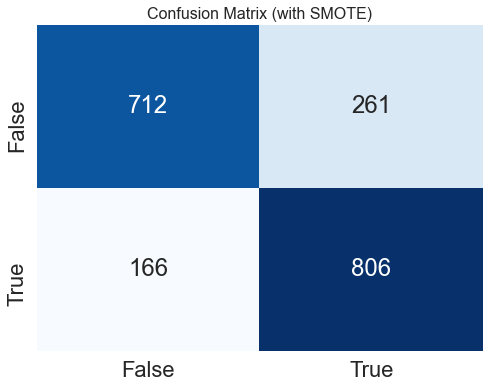

In [142]:
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix

print(f'Accuracy = {accuracy_score(y_test, y_predict):.2f}\nRecall = {recall_score(y_test, y_predict):.2f}\n')
cm = confusion_matrix(y_test, y_predict)
plt.figure(figsize=(8, 6))
plt.title('Confusion Matrix (with SMOTE)', size=16)
sns.heatmap(cm, annot=True, cmap='Blues', cbar=False, fmt='d', yticklabels=['False','True'], xticklabels=['False','True']);

**Tunning Logistic Regression Model**

In [151]:
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
selected_features = SelectKBest(f_classif, k=10).fit(X_train, y_train)

In [152]:
selected_features_df = pd.DataFrame({'Feature':list(predictors),
                                    'Scores':selected_features.scores_})
selected_features_df.sort_values(by="Scores", ascending=False)

,Feature,Scores
10,age.sq,4267.150997
1,age,4082.233615
11,age.sqrt,3407.372126
12,age.log,2106.176906
4,ever_married,763.961888
13,avg_glucose_level.sq,596.691321
7,avg_glucose_level,573.997426
2,hypertension,553.666325
17,avg_glucose_level.sqrt,544.901537
3,heart_disease,527.166651


In [150]:
selected_features = SelectKBest(mutual_info_classif).fit(X_train, y_train)
selected_features_df = pd.DataFrame({'Feature':list(predictors),
                                    'Scores':selected_features.scores_})
selected_features_df.sort_values(by="Scores", ascending=False)

,Feature,Scores
11,age.sqrt,0.511845
12,age.log,0.506911
1,age,0.506432
10,age.sq,0.505035
16,bmi.log,0.446544
15,bmi.sq,0.442749
8,bmi,0.442662
18,bmi.sqrt,0.436636
9,smoking_status,0.337755
5,work_type,0.250880


In [94]:
from sklearn.feature_selection import f_regression
t_statistic = f_regression(X_train, y_train)[0]
p_values = f_regression(X_train, y_train)[1]

In [95]:
tuple(zip(predictors, np.round(p_values,5)))

(('gender', 0.00209),
 ('age', 0.0),
 ('hypertension', 0.0),
 ('heart_disease', 0.0),
 ('ever_married', 0.0),
 ('work_type', 0.0),
 ('Residence_type', 1e-05),
 ('avg_glucose_level', 0.0),
 ('bmi', 0.0),
 ('smoking_status', 0.0),
 ('age.sq', 0.0),
 ('age.log', 0.0),
 ('avg_glucose_level.sq', 0.0),
 ('avg_glucose_level.log', 0.0),
 ('bmi.sq', 4e-05),
 ('bmi.log', 0.0))

In [88]:
pd.concat([np.array(predictors), np.array(p_values)], axis=1)

TypeError: cannot concatenate object of type '<class 'numpy.ndarray'>'; only Series and DataFrame objs are valid

In [81]:
sns.catplot(x=predictors, y=p_values, kind='bar')

TypeError: object of type 'NoneType' has no len()

Models todo:  
Cat Boost  
XGBoost  
Random Forest  
Neural Nets  

**Cat Boost**

In [120]:
from catboost import CatBoostClassifier, Pool 
model_cb = CatBoostClassifier(iterations=1000, 
                              task_type="GPU",
                              devices='0:1',
                              verbose=False)

In [121]:
predictors = df.columns[:10]
target = 'stroke'

X = df[predictors].values
y = df[target].astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
model_cb.fit(X_train.tolist(), list(y_train))

In [122]:
y_predict = model_cb.predict(X_test.tolist())

In [123]:
print_precision_recall_f1(y_test, y_predict)

True Positive 2
True Negative 936
False Negative 41
False Positive 3
Precision 0.4
Recall 0.046511627906976744
F1 Score 0.08333333333333333


In [124]:
accuracy = (y_predict == y_test)
np.array(accuracy).mean()

0.955193482688391

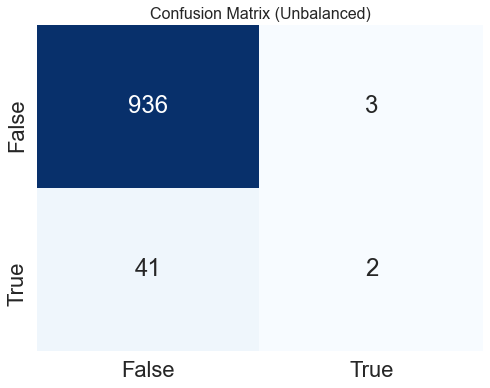

In [127]:
print_cm(y_test, y_predict, title="Confusion Matrix (Unbalanced)")

Applying SMOTE balancing

In [ ]:
# Use SMOTE to upsample the training data only on the 
def smote(X_train, y_train):
    smt = SMOTE(n_jobs=-1)
    X_train, y_train = smt.fit_resample(X_train, y_train)
    return X_train, y_train

In [151]:
from imblearn.over_sampling import RandomOverSampler

model_cb = CatBoostClassifier(iterations=1000, 
                              task_type="GPU",
                              devices='0:1',
                              verbose=False)

predictors = df.columns[:10]
target = 'stroke'

X = df[predictors].values
y = df[target].astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Apply SMOTE
X_train, y_train = RandomOverSampler(sampling_strategy=0.5).fit_resample(X_train, y_train)

model_cb.fit(X_train.tolist(), list(y_train))

y_predict = model_cb.predict(X_test.tolist())

In [152]:
X_train.shape

(5641, 10)

In [153]:
y_train.shape

(5641,)

In [155]:
y_train.value_counts()

0    3761
1    1880
Name: stroke, dtype: int64

In [149]:
print_precision_recall_f1(y_test, y_predict)
accuracy = (y_predict == y_test)
np.array(accuracy).mean()

True Positive 0
True Negative 939
False Negative 43
False Positive 0
Precision 0
Recall 0.0
F1 Score 0


0.9562118126272913

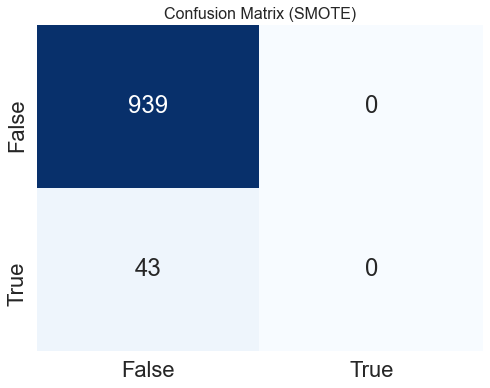

In [150]:
print_cm(y_test, y_predict, title="Confusion Matrix (SMOTE)")